# Jupyter Notebook with SkLearn and Linear Regression

In statistics, linear regression is a model that estimates the linear relationship between a dependent variable, what you're trying to figure out, and one or more explanatory variables (regressor or independent variable). A model with exactly one explanatory variable is a simple linear regression; a model with two or more explanatory variables is a multiple linear regression.  This term is distinct from multivariate linear regression, which predicts multiple correlated dependent variables rather than a single dependent variable.

Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities.

**References:**

+ https://en.wikipedia.org/wiki/Linear_regression

+ https://scikit-learn.org/stable/

In [1]:
# Let's define some variables (information holders) for our project overall

global PROJECT_ID, BUCKET_NAME, LOCATION
BUCKET_NAME =""
PROJECT_ID  =""
LOCATION    =""

BOLD_START="\033[1m"
BOLD_END="\033[0m"

In [5]:
# Import key libraries necessary to support dynamic installation of additional libraries
# Use subprocess to support running operating system commands from the program, using the "bang" (!)
# symbology is supported, however that does not translate to an actual python script, this is a more
# agnostic approach.
###########################################
#- Minimal imports to start
###########################################
try:
    import sys
    import subprocess
    import importlib.util
    import atexit
    import os
except ImportError as e:
    print("There was a problem importing the most basic libraries necessary for this code.")
    print(repr(e))
    raise SystemExit("Stop right there!")

###########################################
#- Final Exit Routine
###########################################
@atexit.register
def goodbye():
    print("GOODBYE")

In [8]:
target_folder="/content/folderOnColab"
target_repo="https://raw.githubusercontent.com//christophergarthwood/jbooks/main"
target_files=["debug.py"]
print(f"Creating a folder ({target_folder}) to store project data.")
subprocess.run(["mkdir", "-p" , target_folder])
if os.path.isdir(target_folder):
  print("Performing wget on:")
  for idx, filename in enumerate(target_files):
    print(f"...{filename} to target folder: {target_folder}")
    try:
      subprocess.run(["wget", f"--directory-prefix={target_folder}", f"{target_repo}/{filename}"])
    except Exception as e:
      print("")
      print(f"ERROR: There was a problem performing wget on the target file ({filename}), see Exception: {str(e)}")
      print("...talk to the instructor.")
    if os.path.isfile(target_folder+os.sep+filename):
      print("...verified copy.")
      print("...importing code.")
      target_filename=f"{target_folder+os.sep+filename}"
      os.environ["target_filename"]=target_filename
      %run $target_filename
    else:
      print(f"...copy NOT verified, check the {target_folder} for the existence of {filename}")
else:
    print("ERROR: Local folder not found/created.  Check the output to ensure your folder is created.")
    print(f"...target folder: {target_folder}")
    print("...if you can't find the problem contact the instructor.")

Creating a folder (/content/folderOnColab) to store project data.
Performing wget on:
...debug.py to target folder: /content/folderOnColab
...verified copy.
...importing code.


In [13]:
###########################################
#- Import External Libraries
###########################################
from pathlib import Path
debug_lib_location = Path(target_folder)
sys.path.append(str(debug_lib_location))

try:
  import debug
  debug.msg_debug("...debug library loaded.")
except ImportError as e:
  rprint("There was a problem importing the debug library.")
  rprint(repr(e))
  raise SystemExit("Without the debug library this code will not run.")

[2025-02-04 21:56:25 UTC]   DEBUG: ...debug library loaded. 
[2025-02-04 21:56:25 UTC]   DEBUG: ...debug library loaded. 
[2025-02-04 21:56:25 UTC]   DEBUG: ...debug library loaded. 


DEBUG:msg_logs:...debug library loaded.


In [14]:
#- Environment Check
import datetime
import platform

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())
current_time   = datetime.datetime.now()
operating_system=platform.system()

if RunningInCOLAB:
    python_environment=" Google Colab "
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"
else:
    python_environment=" Python command-line "

print(f"You are running this notebook in {python_environment} at {BOLD_START}{current_time}{BOLD_END} on {BOLD_START}{operating_system}{BOLD_END} in the {BOLD_START}{PROJECT_ID}{BOLD_END} lab.")

You are running this notebook in  Google Colab  at 2025-02-04 21:56:28.960957 on Linux in the  lab.


In [15]:
libraries=["numpy", "pandas", "scipy", "sklearn", "matplotlib",
           "rich", "rich[jupyter]", "unidecode", "icecream",
           "polars[all]", "dask[complete]", "xarray",
           "tqdm", "watermark",
           "Pillow",]

import importlib.util

for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

Library numpy already installed.
Library pandas already installed.
Library scipy already installed.
Library sklearn already installed.
Library matplotlib already installed.
Library rich already installed.
Installing library rich[jupyter]


CompletedProcess(args=['pip', 'install', 'rich[jupyter]', '--quiet'], returncode=0)

Library unidecode already installed.
Library icecream already installed.
Installing library polars[all]


CompletedProcess(args=['pip', 'install', 'polars[all]', '--quiet'], returncode=0)

Installing library dask[complete]


CompletedProcess(args=['pip', 'install', 'dask[complete]', '--quiet'], returncode=0)

Library xarray already installed.
Library tqdm already installed.
Library watermark already installed.


## Includes and Libraries

In [43]:
############################################
# INCLUDES
############################################
#Generally useful / common libraries
import os
import subprocess
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
from pathlib import Path

#Data Science
import numpy as np
import pandas as pd
import polars as pl
import dask as da
import xarray as xr

#Pretty Print
from rich import print as rprint
from icecream import ic
from tqdm.notebook import trange, tqdm
from watermark import watermark as the_watermark

#libraries specific to this example
import scipy as sp
from sklearn.linear_model import LinearRegression

#- Graphics
import matplotlib.pyplot as plt
import matplotlib as matplt
import matplotlib
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
from matplotlib.pyplot import imshow
from matplotlib.patches import Circle
from PIL import Image as PIL_Image
import PIL.ImageOps

#- Image meta-data for Section 508 compliance
import piexif
from piexif.helper import UserComment

#- Additional libraries for this work
import math
from base64 import b64decode
#from IPython.display import Image, Markdown
from IPython.display import Image, Markdown
import pandas, IPython.display as display, io, jinja2, base64
import requests
import unidecode

## Functions

In [44]:
# Functions are like legos that do one thing, this function outputs library version history of effort.
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=20
    package_version_length=10

    data_version_release="-".join([str(VERSION_NAME),str(VERSION_MAJOR), str(VERSION_MINOR), str(VERSION_RELEASE)])
    rprint(f"Software Version Information: {data_version_release}")
    rprint("\n")
    # Show notebook details
    #%watermark?
    #%watermark --github_username christophergwood --email christopher.g.wood@gmail.com --date --time --iso8601 --updated --python --conda --hostname --machine --githash --gitrepo --gitbranch --iversions --gpu
    # Watermark
    rprint(the_watermark(author=f"{AUTHOR_NAME}", github_username=f"GITHUB_USERNAME", email=f"{AUTHOR_EMAIL}",iso8601=True, datename=True, current_time=True, python=True, updated=True, hostname=True, machine=True, gitrepo=True, gitbranch=True, githash=True))


    print(f"{BOLD_START}Packages:{BOLD_END}")
    print("")
    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas", "seaborn"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             rprint(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        rprint(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        rprint(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        rprint(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        rprint(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        rprint(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        rprint(f"{'     count':<40}#: {torch.cuda.device_count()}")
        rprint(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass

    return

In [45]:
# Routines designed to support adding ALT text to an image generated through Matplotlib.

def capture(figure):
   buffer = io.BytesIO()
   figure.savefig(buffer)
   #return F"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
   return F"data:image/jpg;base64,{base64.b64encode(buffer.getvalue()).decode()}"

def make_accessible(figure, template, **kwargs):
   return display.Markdown(F"""![]({capture(figure)} "{template.render(**globals(), **kwargs)}")""")


# requires JPG's or TIFFs
def add_alt_text(image_path, alt_text):
    try:
        if os.path.isfile(image_path):
          img = PIL_Image.open(image_path)
          if "exif" in img.info:
              exif_dict = piexif.load(img.info["exif"])
          else:
              exif_dict={}

          w, h = img.size
          if "0th" not in exif_dict:
            exif_dict["0th"]={}
          exif_dict["0th"][piexif.ImageIFD.XResolution] = (w, 1)
          exif_dict["0th"][piexif.ImageIFD.YResolution] = (h, 1)

          software_version=" ".join(["STEM-001 with Python v", str(sys.version).split(" ")[0]])
          exif_dict["0th"][piexif.ImageIFD.Software]=software_version.encode("utf-8")

          if "Exif" not in exif_dict:
            exif_dict["Exif"]={}
          exif_dict["Exif"][piexif.ExifIFD.UserComment] = UserComment.dump(alt_text, encoding="unicode")

          exif_bytes = piexif.dump(exif_dict)
          img.save(image_path, "jpeg", exif=exif_bytes)
        else:
          rprint(f"Cound not fine {image_path} for ALT text modification, please check your paths.")

    except (FileExistsError, FileNotFoundError, Exception) as e:
        process_exception(e)

# Appears to solve a problem associated with GPU use on Colab, see: https://github.com/explosion/spaCy/issues/11909
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"


In [46]:
# this function displays the stack trace on errors from a central location making adjustments to the display on an error easier to manage
# functions perform useful solutions for highly repetitive code
def process_exception(inc_exception: Exception) -> None:
  try:
    if DEBUG_STACKTRACE==1:
      traceback.print_exc()
      console.print_exception(show_locals=True)
    else:
      rprint(repr(inc_exception))
  except Exception as e:
    rprint(repr(inc_exception))

In [47]:
#library configurations examples using Pandas
def setup_libary_configuration() -> None:
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 14,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

    #nump equivalent
    np.set_printoptions(precision=4)

# Variable declaration

In [48]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "SKLearn"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

# API Parameters for things like WordCloud, variables help hold information for later use
# The "constants" represent variables that we don't anticipate changing over the course of the program.
IMG_BACKGROUND="black"     #options are black, white, another color or None
IMG_FONT_SIZE_MIN=10
IMG_WIDTH=1024
IMG_HEIGHT=768
IMG_INTERP="bilinear"
IMG_ALPHA=0.8
IMG_ASPECT="equal"
FIGURE_WIDTH=11
FIGURE_HEIGHT=8.5
WORD_FREQ=10

# specify how image formats will be saved
IMG_EXT=".jpg"

# used to fully display the error stack, set to 1 if you want to see a ridiculous amount of debugging information
DEBUG_STACKTRACE=0

# location of our working files
WORKING_FOLDER="/content/folderOnColab"

# Notebook Author details
AUTHOR_NAME="Christopher G Wood"
GITHUB_USERNAME="christophergarthwood"
AUTHOR_EMAIL="christopher.g.wood@gmail.com"

# Encoding
ENCODING  ="utf-8"
os.environ['PYTHONIOENCODING']=ENCODING

############################################
# GLOBAL CONSTANTS
############################################
TEMPERATURE="Temp(C)"
SALINITY="Sal(PSU)"

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

# Library Invocation
### Note that it's also useful to use this code so that you carry around a list of version dependencies and know how you did something (version)

In [49]:
setup_libary_configuration()
lib_diagnostics()

Software Version Information: SKLearn-0-0-1

Author: Christopher G Wood

Github username: GITHUB_USERNAME

Email: christopher.g.wood@gmail.com

Last updated: 2025-02-04T22:04:48.825428+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.167+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: dffc3f077cb0

Git hash: 

Git repo: 

Git branch:

Packages:



nltk                                    #: 3.9.1

numpy                                   #: 1.26.4

pandas                                  #: 2.2.2

seaborn                                 #: 0.13.2

# Data Read
### Using pandas read in a data file and establish a log for output.

In [50]:
# Create the folder that will hold our content.
target_folder=WORKING_FOLDER

debug.msg_info(f"Creating a folder ({target_folder}) to store project data.")

try:
  if os.path.isfile(target_folder):
    raise OSError("Cannot create your folder a file of the same name already exists there, work with your instructor or remove it yourself.")
  elif os.path.isdir(target_folder):
    debug.msg_debug(f"The folder named ({target_folder}) {BOLD_START}already exists{BOLD_END}, we won't try to create a new folder.")
  else:
    subprocess.run(["mkdir", "-p" , target_folder], check=True)
except (subprocess.CalledProcessError, Exception) as e:
  process_exception(e)

[2025-02-04 22:04:49 UTC]    INFO: Creating a folder (/content/folderOnColab) to store project data. 
[2025-02-04 22:04:49 UTC]    INFO: Creating a folder (/content/folderOnColab) to store project data. 
[2025-02-04 22:04:49 UTC]    INFO: Creating a folder (/content/folderOnColab) to store project data. 


INFO:msg_logs:Creating a folder (/content/folderOnColab) to store project data.


[2025-02-04 22:04:49 UTC]   DEBUG: The folder named (/content/folderOnColab) already exists, we won't try to create a new folder. 
[2025-02-04 22:04:49 UTC]   DEBUG: The folder named (/content/folderOnColab) already exists, we won't try to create a new folder. 
[2025-02-04 22:04:49 UTC]   DEBUG: The folder named (/content/folderOnColab) already exists, we won't try to create a new folder. 


DEBUG:msg_logs:The folder named (/content/folderOnColab) already exists, we won't try to create a new folder.


In [51]:
# Download a data file to support the next exercise
# https://drive.google.com/file/d/1CZ_UDQwmQzsowYRSrR3i3LANG2unxvgL/view?usp=share_link

target_files=["1CZ_UDQwmQzsowYRSrR3i3LANG2unxvgL"]
target_filenames=["mooring_data.txt"]
for idx, the_name in enumerate(target_files):
  try:
    debug.msg_debug(f"...downloading {target_filenames[idx]}.")
    subprocess.run(["gdown", f"{the_name}", "--no-check-certificate",  "--continue", "-O", f"{target_folder}{os.sep}{target_filenames[idx]}"], check=True)
  except (subprocess.CalledProcessError, Exception) as e:
    process_exception(e)
    raise SystemError

[2025-02-04 22:04:49 UTC]   DEBUG: ...downloading mooring_data.txt. 
[2025-02-04 22:04:49 UTC]   DEBUG: ...downloading mooring_data.txt. 
[2025-02-04 22:04:49 UTC]   DEBUG: ...downloading mooring_data.txt. 


DEBUG:msg_logs:...downloading mooring_data.txt.


CompletedProcess(args=['gdown', '1CZ_UDQwmQzsowYRSrR3i3LANG2unxvgL', '--no-check-certificate', '--continue', '-O', '/content/folderOnColab/mooring_data.txt'], returncode=0)

In [52]:
debug.msg_info("Files downloaded:")
cmd=["ls ", "-al", f"{target_folder}{os.sep}*.txt",]
completed_process=subprocess.run(cmd, check=True, shell=True, capture_output=True, text=True)
if (completed_process.returncode==0):
  debug.msg_debug(completed_process.stdout)
else:
  debug.msg_warning(f"Command failed with error code of: {completed_process.returncode}")

[2025-02-04 22:04:54 UTC]    INFO: Files downloaded: 
[2025-02-04 22:04:54 UTC]    INFO: Files downloaded: 
[2025-02-04 22:04:54 UTC]    INFO: Files downloaded: 


INFO:msg_logs:Files downloaded:


[2025-02-04 22:04:54 UTC]   DEBUG: All_flo-thru.dat
folderOnColab
 
[2025-02-04 22:04:54 UTC]   DEBUG: All_flo-thru.dat
folderOnColab
 
[2025-02-04 22:04:54 UTC]   DEBUG: All_flo-thru.dat
folderOnColab
 


DEBUG:msg_logs:All_flo-thru.dat
folderOnColab



In [72]:
# Now, setup a variable to store the actual content in the file
data=pd.DataFrame()
target_filename=target_folder+os.sep+"mooring_data.txt"
data_filename=target_filename

# check for the file's existence
if os.path.isfile(target_filename):
  #open the file, read the contents and close the file
  try:
    with open(target_filename, 'r') as file:
        df = pd.read_csv(target_filename, delimiter='^')
        log_file = target_folder+os.sep+"feature_1_batch_1.log"
  except (FileNotFoundError,PermissionError,IOError,UnicodeDecodeError, Exception) as e:
    process_exception(e)
else:
    debug.msg_warning("ERROR: File not found.  Check the previous code block to ensure you file copied.")
    debug.msg_warning(f"...target file: {target_filename}")
    debug.msg_warning("...if you can't find the problem contact the instructor.")
    raise SystemError

if len(df)<1:
    debug.msg_warning("ERROR: There is no content in your data variable.")
    debug.msg_warning("...Verify you copied the input file correctly.")
    debug.msg_warning("...if you can't find the problem contact the instructor.")
else:
    debug.msg_debug(f"It appears your data file was read, your data file has {len(df):,} elements of data.")
    ic(len(df))

[2025-02-04 22:07:25 UTC]   DEBUG: It appears your data file was read, your data file has 54,225 elements of data. 
[2025-02-04 22:07:25 UTC]   DEBUG: It appears your data file was read, your data file has 54,225 elements of data. 
[2025-02-04 22:07:25 UTC]   DEBUG: It appears your data file was read, your data file has 54,225 elements of data. 


DEBUG:msg_logs:It appears your data file was read, your data file has 54,225 elements of data.
ic| len(df): 54225


54225

In [54]:
df

,Time(ms),Depth(m),Pres(dbar),Temp(C),Cond(S/m),Sal(PSU),a650__,a676__,a715__,c510__,c532__,c555__,a412__,a440__,a488__,c650__,c676__,c715__,a510__,a532__,a555__,c412__,c440__,c488__,Beta(470),BetaP(470),bbP(470),bb(470),Beta(532),BetaP(532),bbP(532),bb(532),Beta(650),BetaP(650),bbP(650),bb(650),CHL(ug/l),PE(ppb),CDOM(ppb)
0,2040,2.412,2.429,20.2413,3.0704,21.2229,0.4937,0.6243,1.1033,3.5300,3.3201,3.1844,1.4887,1.0134,0.5575,2.8008,2.8194,3.1858,0.4455,0.3645,0.2978,5.1486,4.4695,3.7681,0.0069,0.0066,0.0458,0.0477,0.0064,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.026,6.5550,14.25
1,2040,2.412,2.429,20.2413,3.0704,21.2229,0.4980,0.6304,1.1030,3.5090,3.2850,3.1376,1.4929,1.0101,0.5514,2.7883,2.8088,3.1958,0.4524,0.3785,0.3112,5.1644,4.4873,3.7736,0.0069,0.0066,0.0458,0.0477,0.0064,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.026,6.5550,14.25
2,2040,2.412,2.429,20.2413,3.0704,21.2229,0.4928,0.6280,1.1028,3.5117,3.2873,3.1304,1.4931,1.0112,0.5544,2.7846,2.7906,3.1749,0.4440,0.3678,0.3091,5.1374,4.4634,3.7422,0.0069,0.0066,0.0458,0.0477,0.0064,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.026,6.5550,14.25
3,2040,2.412,2.429,20.2413,3.0704,21.2229,0.4971,0.6335,1.1029,3.4770,3.2759,3.1041,1.4878,1.0115,0.5573,2.7509,2.7710,3.1591,0.4454,0.3646,0.3054,5.1009,4.4448,3.7302,0.0069,0.0066,0.0458,0.0477,0.0064,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.026,6.5550,14.25
4,2040,2.412,2.429,20.2413,3.0704,21.2229,0.4967,0.6282,1.1030,3.4634,3.2572,3.1007,1.4938,1.0085,0.5575,2.7412,2.7642,3.1495,0.4489,0.3762,0.3159,5.0973,4.4279,3.7267,0.0069,0.0066,0.0458,0.0477,0.0064,0.0063,0.0434,0.0446,0.0056,0.0056,0.0384,0.0389,0.026,6.5550,14.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54220,284457140,0.229,0.231,14.3813,0.0098,0.0601,0.9913,0.9685,0.8631,2.3599,2.2621,2.2948,1.1631,1.1353,1.0944,2.2366,2.1823,2.1723,1.0586,1.0248,1.0254,2.4536,2.4732,2.4244,0.0289,0.0287,0.1981,0.2000,0.0333,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.260,1.0051,12.50
54221,284457140,0.229,0.231,14.3813,0.0098,0.0601,0.9876,0.9696,0.8609,2.3624,2.2611,2.2881,1.1690,1.1442,1.1110,2.2254,2.1738,2.1644,1.0807,1.0397,1.0331,2.4503,2.4730,2.4286,0.0289,0.0287,0.1981,0.2000,0.0333,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.260,1.0051,12.50
54222,284457140,0.229,0.231,14.3813,0.0098,0.0601,0.9801,0.9617,0.8573,2.3703,2.2693,2.2966,1.1508,1.1282,1.0959,2.2297,2.1742,2.1628,1.0771,1.0435,1.0429,2.4417,2.4616,2.4161,0.0289,0.0287,0.1981,0.2000,0.0333,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.260,1.0051,12.50
54223,284457140,0.229,0.231,14.3813,0.0098,0.0601,0.9703,0.9556,0.8595,2.3600,2.2597,2.2874,1.1691,1.1414,1.1019,2.2253,2.1725,2.1642,1.0676,1.0275,1.0254,2.4457,2.4659,2.4177,0.0289,0.0287,0.1981,0.2000,0.0333,0.0331,0.2288,0.2300,0.0134,0.0133,0.0919,0.0924,0.260,1.0051,12.50


In [55]:
#what does the data domain look like?
print(df.columns)

Index([' Time(ms)', 'Depth(m)', 'Pres(dbar)', 'Temp(C)', 'Cond(S/m)',
       'Sal(PSU)', 'a650__', 'a676__', 'a715__', 'c510__', 'c532__', 'c555__',
       'a412__', 'a440__', 'a488__', 'c650__', 'c676__', 'c715__', 'a510__',
       'a532__', 'a555__', 'c412__', 'c440__', 'c488__', 'Beta(470)',
       'BetaP(470)', 'bbP(470)', 'bb(470)', 'Beta(532)', 'BetaP(532)',
       'bbP(532)', 'bb(532)', 'Beta(650)', 'BetaP(650)', 'bbP(650)', 'bb(650)',
       'CHL(ug/l)', 'PE(ppb)', 'CDOM(ppb)'],
      dtype='object')


In [56]:
#learn pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54225 entries, 0 to 54224
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0    Time(ms)   54225 non-null  int64  
 1   Depth(m)    54225 non-null  float64
 2   Pres(dbar)  54225 non-null  float64
 3   Temp(C)     54225 non-null  float64
 4   Cond(S/m)   54225 non-null  float64
 5   Sal(PSU)    54225 non-null  float64
 6   a650__      54225 non-null  float64
 7   a676__      54225 non-null  float64
 8   a715__      54225 non-null  float64
 9   c510__      54221 non-null  float64
 10  c532__      54224 non-null  float64
 11  c555__      54225 non-null  float64
 12  a412__      54191 non-null  float64
 13  a440__      54196 non-null  float64
 14  a488__      54213 non-null  float64
 15  c650__      54225 non-null  float64
 16  c676__      54225 non-null  float64
 17  c715__      54225 non-null  float64
 18  a510__      54221 non-null  float64
 19  a532__      54224 non-nul

In [57]:
#learn MORE pandas
df.describe()

,Time(ms),Depth(m),Pres(dbar),Temp(C),Cond(S/m),Sal(PSU),a650__,a676__,a715__,c510__,c532__,c555__,a412__,a440__,a488__,c650__,c676__,c715__,a510__,a532__,a555__,c412__,c440__,c488__,Beta(470),BetaP(470),bbP(470),bb(470),Beta(532),BetaP(532),bbP(532),bb(532),Beta(650),BetaP(650),bbP(650),bb(650),CHL(ug/l),PE(ppb),CDOM(ppb)
count,5.4225e+04,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54221.0000,54224.0000,54225.0000,54191.0000,54196.0000,54213.0000,54225.0000,54225.0000,54225.0000,54221.0000,54224.0000,54225.0000,54191.0000,54196.0000,54213.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,5.4225e+04,5.4225e+04,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000,54225.0000
mean,1.4227e+08,2.4052,2.4217,20.4734,3.3244,23.0135,0.8114,0.9437,1.3253,9.5783,9.2298,8.9078,2.6291,1.9385,1.2406,7.9972,7.8911,8.0785,1.0437,0.8942,0.7655,11.9528,11.0601,9.9888,0.0192,0.0190,0.1311,0.1330,0.0198,0.0196,0.1354,1.3657e-01,1.0438e-02,0.0104,0.0717,0.0722,0.0559,9.7436,15.9809
std,8.2600e+07,0.2680,0.2698,1.0591,0.4264,2.9027,0.3246,0.3143,0.2478,6.6257,6.4534,6.2585,1.2619,0.9932,0.7120,5.6439,5.5148,5.3098,0.6155,0.5377,0.4690,7.5336,7.2587,6.8097,0.0140,0.0140,0.0965,0.0965,0.0146,0.0146,0.1012,1.0118e-01,3.3884e-03,0.0034,0.0234,0.0234,0.0470,2.3775,3.8851
min,2.0400e+03,0.2290,0.2310,11.7240,0.0078,0.0504,0.4563,0.5952,0.8372,1.4566,1.5006,1.4971,1.1315,0.8825,0.4856,1.4898,1.4563,1.4207,0.3870,0.3195,0.2645,1.6440,1.5628,1.5090,0.0038,0.0035,0.0242,0.0261,0.0000,-0.0002,-0.0011,5.0000e-05,-4.3000e-05,-0.0001,-0.0007,-0.0003,-0.2990,0.1311,1.2500
25%,7.0246e+07,2.3610,2.3770,20.2524,3.1963,22.3201,0.5177,0.6567,1.1140,3.7241,3.5308,3.3853,1.5077,1.0601,0.6071,3.0417,3.0598,3.4457,0.4949,0.4126,0.3447,5.2797,4.6340,3.9649,0.0070,0.0068,0.0467,0.0486,0.0071,0.0070,0.0481,4.9204e-02,6.7370e-03,0.0067,0.0461,0.0466,0.0260,8.0845,13.0000
50%,1.4223e+08,2.4360,2.4530,20.6635,3.3494,23.1836,0.7607,0.9061,1.2581,7.6110,7.3485,7.1147,2.2561,1.6576,1.1207,6.4864,6.4372,6.7186,0.9416,0.8064,0.6852,9.4410,8.7325,7.9165,0.0159,0.0156,0.1079,0.1098,0.0160,0.0159,0.1097,1.1084e-01,1.3359e-02,0.0133,0.0919,0.0924,0.0520,9.5703,15.2500
75%,2.1421e+08,2.5050,2.5220,21.0876,3.5465,24.3282,0.9888,1.1141,1.4475,13.3235,12.8400,12.3631,3.4218,2.5158,1.6022,10.9789,10.7714,10.8128,1.3490,1.1719,1.0171,16.6472,15.4271,13.9145,0.0256,0.0253,0.1750,0.1769,0.0256,0.0255,0.1762,1.7732e-01,1.3359e-02,0.0133,0.0919,0.0924,0.0910,11.7553,18.5000
max,2.8446e+08,2.8280,2.8470,21.3571,4.0005,28.3290,2.8148,2.7860,2.7880,38.2055,38.0095,37.4525,10.7763,7.3083,5.3478,35.3903,34.6212,33.8259,4.9868,4.3927,3.7886,38.2229,37.9593,38.1613,0.0588,0.0585,0.4045,0.4064,0.0577,0.0575,0.3977,3.9880e-01,1.3359e-02,0.0133,0.0919,0.0924,0.3900,15.4261,29.0000


# Prep the data

In [58]:
from ctypes import DEFAULT_MODE
#PURGE DATA
debug.msg_info("Data scrub and prep")
#load teperature (referenced by name) for all values (y, x); (all rows, column=Temp)
#into a single dimensional array that is Numpy based (means you got lots of free powerful tools)

try:
    xs=df.loc[:,TEMPERATURE].values
    debug.msg_debug("XS array from " + str(TEMPERATURE) + " is " + str(xs.size))
except (KeyError, Exception) as e:
    debug.msg_warning(f"Exception found")
    debug.msg_error("'TEMPERATURE' key values were not found, please check your file.")
    process_exception(e)

try:
    ys=df.loc[:,SALINITY].values
    debug.msg_debug("YS array from " + SALINITY + " is " + str(ys.size))
except (KeyError, Exception) as e:
    debug.msg_warning(f"Exception found")
    debug.msg_error("'SALINITY' key values were not found, please check your file.")
    process_exception(e)


#machine learning doesn't like negative numbers, there are multiple ways of doing this
#pd.DataFrame().query() or np.where() are some options
#LEARN PANDAS!!!!
debug.msg_debug("")
debug.msg_debug("Performing Y mask cleaning")
y_mask=np.where(ys < 1)
debug.msg_debug("")

#clear out the values that should be scrubbed.  Again, any technique to clean the data is viable.
all_xs = np.delete(xs, y_mask)
debug.msg_debug("all_xs (> 1) array from " + TEMPERATURE + " is " + str(all_xs.size))
all_ys = np.delete(ys, y_mask)
debug.msg_debug("all_ys (> 1) array from " + SALINITY + " is " + str(all_ys.size))

[2025-02-04 22:04:55 UTC]    INFO: Data scrub and prep 
[2025-02-04 22:04:55 UTC]    INFO: Data scrub and prep 
[2025-02-04 22:04:55 UTC]    INFO: Data scrub and prep 


INFO:msg_logs:Data scrub and prep


[2025-02-04 22:04:55 UTC]   DEBUG: XS array from Temp(C) is 54225 
[2025-02-04 22:04:55 UTC]   DEBUG: XS array from Temp(C) is 54225 
[2025-02-04 22:04:55 UTC]   DEBUG: XS array from Temp(C) is 54225 


DEBUG:msg_logs:XS array from Temp(C) is 54225


[2025-02-04 22:04:55 UTC]   DEBUG: YS array from Sal(PSU) is 54225 
[2025-02-04 22:04:55 UTC]   DEBUG: YS array from Sal(PSU) is 54225 
[2025-02-04 22:04:55 UTC]   DEBUG: YS array from Sal(PSU) is 54225 


DEBUG:msg_logs:YS array from Sal(PSU) is 54225


[2025-02-04 22:04:55 UTC]   DEBUG:  
[2025-02-04 22:04:55 UTC]   DEBUG:  
[2025-02-04 22:04:55 UTC]   DEBUG:  


DEBUG:msg_logs:


[2025-02-04 22:04:55 UTC]   DEBUG: Performing Y mask cleaning 
[2025-02-04 22:04:55 UTC]   DEBUG: Performing Y mask cleaning 
[2025-02-04 22:04:55 UTC]   DEBUG: Performing Y mask cleaning 


DEBUG:msg_logs:Performing Y mask cleaning


[2025-02-04 22:04:55 UTC]   DEBUG:  
[2025-02-04 22:04:55 UTC]   DEBUG:  
[2025-02-04 22:04:55 UTC]   DEBUG:  


DEBUG:msg_logs:


[2025-02-04 22:04:55 UTC]   DEBUG: all_xs (> 1) array from Temp(C) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_xs (> 1) array from Temp(C) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_xs (> 1) array from Temp(C) is 53550 


DEBUG:msg_logs:all_xs (> 1) array from Temp(C) is 53550


[2025-02-04 22:04:55 UTC]   DEBUG: all_ys (> 1) array from Sal(PSU) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_ys (> 1) array from Sal(PSU) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_ys (> 1) array from Sal(PSU) is 53550 


DEBUG:msg_logs:all_ys (> 1) array from Sal(PSU) is 53550


In [59]:
#example of all_xs output (temperature)
rprint(all_xs)

[20.2413 20.2413 20.2413 ... 18.7201 18.7201 18.7201]

In [60]:
#transpose the data, the API expects it
all_xs = np.transpose([all_xs])
debug.msg_debug("all_xs (transposed) array from " +  TEMPERATURE + " is " + str(all_xs.size))

all_ys = np.transpose([all_ys])
debug.msg_debug("all_ys (transposed) array from " +  SALINITY + " is " + str(all_ys.size))


[2025-02-04 22:04:55 UTC]   DEBUG: all_xs (transposed) array from Temp(C) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_xs (transposed) array from Temp(C) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_xs (transposed) array from Temp(C) is 53550 


DEBUG:msg_logs:all_xs (transposed) array from Temp(C) is 53550


[2025-02-04 22:04:55 UTC]   DEBUG: all_ys (transposed) array from Sal(PSU) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_ys (transposed) array from Sal(PSU) is 53550 
[2025-02-04 22:04:55 UTC]   DEBUG: all_ys (transposed) array from Sal(PSU) is 53550 


DEBUG:msg_logs:all_ys (transposed) array from Sal(PSU) is 53550


In [61]:
#example of all_xs output now (tafter transpose)
print(all_xs)

[[20.2413]
 [20.2413]
 [20.2413]
 ...
 [18.7201]
 [18.7201]
 [18.7201]]


# Statistics
### Lots of statistics at your fingertips with Numpy
### Also useful as it helps with quick operations for other functions (plotting, data smoothing, etc.)

In [62]:
#STATISTICS
x_mean=df[TEMPERATURE].apply(np.mean)
x_std=df[TEMPERATURE].apply(np.std)
x_mean_max=np.max(x_mean)
x_std_max=np.max(x_std)
x_range_limit=x_mean_max + (x_std_max * 5)

y_mean=df[SALINITY].apply(np.mean)
y_std=df[SALINITY].apply(np.std)
y_mean_max=np.max(y_mean)
y_std_max=np.max(y_std)
y_range_limit=y_mean_max + (y_std_max * 5)

# Plots

In [84]:
#create the image in the background and render with 508 compliance taken into account
# Use the 'Agg' backend for non-interactive environments
matplt.use('Agg')

#show the image inline
#%matplotlib inline
PLT_LGD_X_OFFSET=1
PLT_LGD_Y_OFFSET=0.5

#establish the initial figure dimensions and configuration (purposely made large 20x10 inches)
fig = plt.figure(1,figsize=(FIGURE_WIDTH,FIGURE_HEIGHT));

#this is where you could have multiple plots side by side
axes = plt.subplot(111);
axes.set_title('X, Y Plot');
axes.set_ylabel(SALINITY);
axes.set_xlabel(TEMPERATURE);

labels=axes.get_xticklabels();
plt.setp(labels,rotation=45,horizontalalignment='right');

axes.scatter(all_xs, all_ys, label='x vs. y');
axes.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET));

# Save the plot to a file that can be pulled up at a later date.
target_filename=target_folder+os.sep+f"004_sklearn{IMG_EXT}";

# Create ALT text describing the image.
caption_text=f"Scatter plot of Salinity on the Y axis versus Temperature on the X axis using data from the datafile {data_filename}, saving results to {target_filename}.";

bit_bucket=plt.text(0.5,
                   0.7,
                  caption_text,
                  rotation=0.0,
                  ha="left",
                  va="center",
                  fontsize=IMG_FONT_SIZE_MIN,
                  family='serif',
                  style='oblique',
                  wrap=True,
                  bbox=dict(boxstyle="round",
                            ec=(1., 0.5, 0.5),
                            fc=(1., 0.8, 0.8),
                            ),
                  transform=fig.transFigure
                  );

#Save
plt.savefig(target_filename);
add_alt_text(target_folder+os.sep+f"004_sklearn{IMG_EXT}", caption_text);
rprint("Next display is a " + caption_text);

Next display is a Scatter plot of Salinity on the Y axis versus Temperature on the X axis using data from the 
datafile /content/folderOnColab/mooring_data.txt, saving results to /content/folderOnColab/004_sklearn.jpg.

![](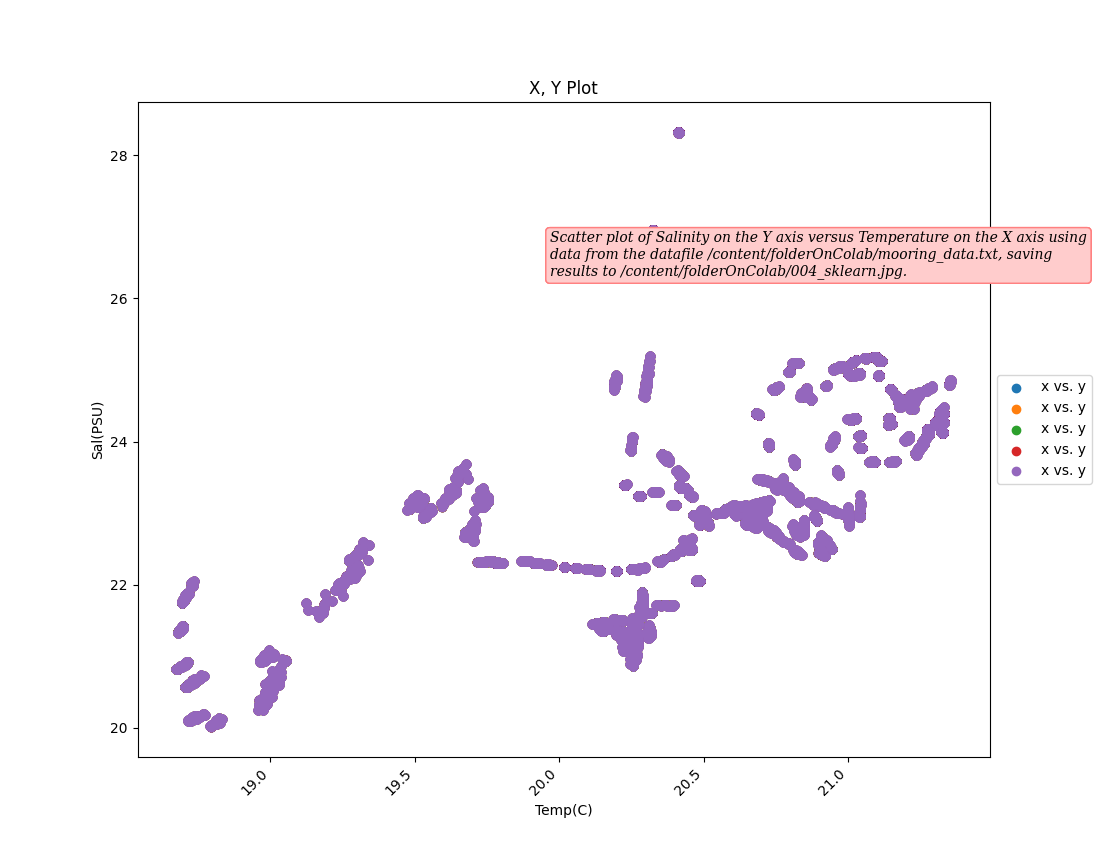 "Scatter plot of Salinity on the Y axis versus Temperature on the X axis using data from the datafile /content/folderOnColab/mooring_data.txt, saving results to /content/folderOnColab/004_sklearn.jpg.")

In [85]:
# Display Section 508 compliant image on the scrren with ALT text
try:
  make_accessible(plt, jinja2.Template(caption_text), len=len)
except (NameError, Exception) as e:
  process_exception(e)

# Linear Regression (SKlearn)

In [76]:
#instantiate the model
lm = LinearRegression()

#fit values with the clean data
lm.fit(all_xs, all_ys)

#run a prediction given the calculation (yeah...that easy)
new_y=lm.predict(all_xs)

LinearRegression()

In [86]:
debug.msg_debug(f"             Intercept:{lm.intercept_}.")
debug.msg_debug(f"Number of Coefficients:{len(lm.coef_)}." )

[2025-02-04 22:13:06 UTC]   DEBUG:              Intercept:[-6.4635]. 
[2025-02-04 22:13:06 UTC]   DEBUG:              Intercept:[-6.4635]. 
[2025-02-04 22:13:06 UTC]   DEBUG:              Intercept:[-6.4635]. 


DEBUG:msg_logs:             Intercept:[-6.4635].


[2025-02-04 22:13:06 UTC]   DEBUG: Number of Coefficients:1. 
[2025-02-04 22:13:06 UTC]   DEBUG: Number of Coefficients:1. 
[2025-02-04 22:13:06 UTC]   DEBUG: Number of Coefficients:1. 


DEBUG:msg_logs:Number of Coefficients:1.


In [87]:
#create the image in the background and render with 508 compliance taken into account
# Use the 'Agg' backend for non-interactive environments
matplt.use('Agg')

#show the image inline
#%matplotlib inline
PLT_LGD_X_OFFSET=1
PLT_LGD_Y_OFFSET=0.5

#establish the initial figure dimensions and configuration (purposely made large 20x10 inches)
fig = plt.figure(1,figsize=(FIGURE_WIDTH,FIGURE_HEIGHT));

#this is where you could have multiple plots side by side
axes = plt.subplot(111)
axes.set_title('Y vs New Y Plot')
axes.set_ylabel(SALINITY)
axes.set_xlabel('Time')

labels=axes.get_xticklabels();
plt.setp(labels,rotation=45,horizontalalignment='right');

axes.scatter(range(0,all_ys.size),all_ys, label='old Y')
axes.scatter(range(0,new_y.size),new_y, label='new Y')
axes.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))

# Save the plot to a file that can be pulled up at a later date.
target_filename=target_folder+os.sep+f"004_sklearn_inference{IMG_EXT}";

# Create ALT text describing the image.
caption_text=f"Scatter plot of Y True versus Y Inference from the datafile {data_filename}, saving results to {target_filename}.";


bit_bucket=plt.text(0.5,
                   0.7,
                  caption_text,
                  rotation=0.0,
                  ha="left",
                  va="center",
                  fontsize=IMG_FONT_SIZE_MIN,
                  family='serif',
                  style='oblique',
                  wrap=True,
                  bbox=dict(boxstyle="round",
                            ec=(1., 0.5, 0.5),
                            fc=(1., 0.8, 0.8),
                            ),
                  transform=fig.transFigure
                  );


#Save
plt.savefig(target_filename);
add_alt_text(target_folder+os.sep+f"004_sklearn_inference{IMG_EXT}", caption_text);
rprint("Next display is a " + caption_text);

Next display is a Scatter plot of Y True versus Y Inference from the datafile 
/content/folderOnColab/mooring_data.txt, saving results to /content/folderOnColab/004_sklearn_inference.jpg.

![](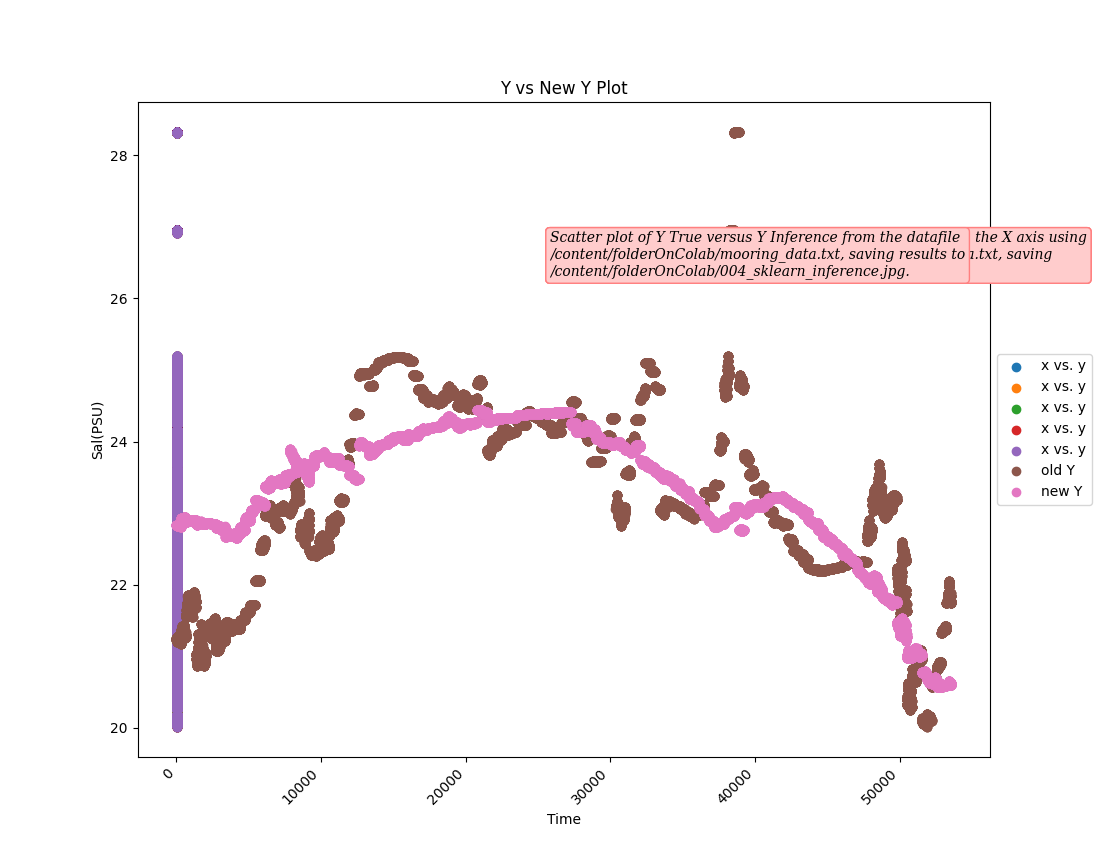 "Scatter plot of Y True versus Y Inference from the datafile /content/folderOnColab/mooring_data.txt, saving results to /content/folderOnColab/004_sklearn_inference.jpg.")

In [88]:
# Display Section 508 compliant image on the scrren with ALT text
try:
  make_accessible(plt, jinja2.Template(caption_text), len=len)
except (NameError, Exception) as e:
  process_exception(e)